# Cognitive Age Prediction with Structural and Functional MRI

## Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve, ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline

def run_ridge(data, subjects_data, alphas=None, train_sizes=None):
    """Helper for running ridge resgression.
    
    Parameters
    ----------
    data : pandas.DataFrame
        Features to be used for predictions.
        
    subjects_data : pandas.DataFrame
        Information about subjects from CamCAN dataset.
        
    alphas : numpy.ndarray
        Values for parameter alpha to be tested using RidgeCV. Default is
        np.logspace(start=-3, stop=1, num=50, base=10.0).
        
    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if alphas is None:
        alphas = np.logspace(start=-3, stop=1, num=50, base=10.0)
    if train_sizes is None:
        train_sizes = np.linspace(.1, 1.0, 5)
    
    # prepare data, subjects age
    data_rnd = data.sample(frac=1)
    y = subjects_data.loc[data_rnd.index.values].age.values
    X = data_rnd.values

    cross_val_scores = np.zeros(len(alphas))
    
    mae = cross_val_score(make_pipeline(StandardScaler(), RidgeCV(alphas)),
                          X, y, scoring='neg_mean_absolute_error',
                          cv=ShuffleSplit(n_splits=CV_STEPS))
    r2 = cross_val_score(make_pipeline(StandardScaler(), RidgeCV(alphas)),
                         X, y, scoring='r2',
                         cv=ShuffleSplit(n_splits=CV_STEPS))
    y_pred = cross_val_predict(make_pipeline(StandardScaler(), RidgeCV(alphas)),
                               X, y, cv=CV_STEPS)
    
    train_sizes, train_scores, test_scores = learning_curve(make_pipeline(StandardScaler(), RidgeCV(alphas)),
                                                            X, y, cv=CV_STEPS, train_sizes=train_sizes)

    return y, y_pred, mae, r2, train_sizes, train_scores, test_scores


def plot_pred(y, y_pred, mae, title='Prediction vs Measured'):
    """Plot predicted values vs real values."""
    plt.figure()
    plt.title(title)
    plt.scatter(y, y_pred,  edgecolor='black')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '-', lw=3, color='green')
    plt.plot([y.min(), y.max()], [y.min() - mae, y.max() - mae], 'k--', lw=3, color='red')
    plt.plot([y.min(), y.max()], [y.min() + mae, y.max() + mae], 'k--', lw=3, color='red')
    plt.xlabel('chronological age')
    plt.ylabel('predicted age')
    plt.grid()
    plt.show()

    
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning Curves', ylim=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------        
    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Numbers of training examples that has been used to generate the learning curve.
        
    train_scores : array, shape (n_ticks, n_cv_folds)
        Scores on training sets.

    test_scores : array, shape (n_ticks, n_cv_folds)
        Scores on test set.

    title : string
        Title for the chart.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    """
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel('Training examples')
    plt.ylabel('Score')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Cross-validation score')

    plt.legend(loc='best')
    plt.show()


## Structural MRI

### Read Data

In [2]:
import pandas as pd

# read information about subjects
subjects_data = pd.read_csv('../../data/participant_data.csv', index_col=0)

subjects_data.head()

,age,hand,gender_text,gender_code,tiv_cubicmm,cbuid700,cbuid280_sess1,cbuid280_sess2,cbuid280_sess3,cbuid280_sess4,profilecode,profilecode_numeric
Observations,,,,,,,,,,,,
CC110033,24,90.0,MALE,1,1413746.0,CBU120746,NaN,NaN,NaN,NaN,NaN,NaN
CC110037,18,89.0,MALE,1,1386581.0,CBU110544,NaN,NaN,NaN,NaN,NaN,NaN
CC110045,24,100.0,FEMALE,2,1385355.0,CBU111116,NaN,NaN,NaN,NaN,NaN,NaN
CC110056,22,100.0,FEMALE,2,1286849.0,CBU110547,NaN,CBU140153,CBU140224,NaN,D,1.0
CC110062,20,58.0,MALE,1,1582719.0,CBU110468,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# read features

# there is a repetition in features, because I didn't handle the exceptions correctly
# save log for the next time

area_data = pd.read_pickle('../../data/structural/area_data.gzip', 
                           compression='gzip')
thickness_data = pd.read_pickle('../../data/structural/thickness_data.gzip',
                               compression='gzip')
volume_data = pd.read_pickle('../../data/structural/volume_data.gzip',
                            compression='gzip')

volume_data.head()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,SupraTentorialVol,SupraTentorialVolNotVent,SupraTentorialVolNotVentVox,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol
Measure:volume,,,,,,,,,,,,,,,,,,,,,
CC310256,16443.3,215.0,14808.5,56803.4,7378.4,3956.5,5018.7,2464.6,1684.8,2822.3,...,1.194657e+06,1.160384e+06,1158424.0,1847752.0,0.718849,0.988205,16.0,7.0,23.0,1.869806e+06
CC110033,6018.2,145.2,13938.6,56055.7,8523.9,3604.6,4557.6,2008.8,971.2,1426.7,...,1.030259e+06,1.014403e+06,1011785.0,1596489.0,0.757157,1.029559,41.0,23.0,64.0,1.550654e+06
CC110037,5150.4,226.8,14923.5,59652.3,7732.1,3223.5,4647.4,2154.4,773.3,1478.8,...,1.032711e+06,1.022294e+06,1019858.0,1618468.0,0.782415,1.072228,19.0,30.0,49.0,1.509444e+06
CC110098,6299.5,269.5,14468.0,59900.4,7368.8,3976.3,5239.7,1884.4,880.3,1790.9,...,1.091133e+06,1.079604e+06,1076145.0,1732368.0,0.740368,1.031667,12.0,28.0,40.0,1.679193e+06
CC110126,2711.6,352.6,16216.5,57535.4,7946.3,3431.7,4875.8,1994.7,726.2,1233.2,...,1.094727e+06,1.088829e+06,1086463.0,1628306.0,0.769026,1.009764,21.0,23.0,44.0,1.612561e+06


In [4]:
# check whether we have any NaN/None values.
thickness_data[thickness_data.isnull().any(axis=1)]

,0,1,2,3,4,5,6,7,8,9,...,5114,5115,5116,5117,5118,5119,5120,5121,5122,5123
CC221585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC620129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC710679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC721704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC722421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
area_data = area_data.dropna()
thickness_data = thickness_data.dropna()
volume_data = volume_data.dropna()

### Training and Prediction

In [6]:
CV_STEPS = 10

#### Area

MAE: 10.97
MAE STD: 0.73


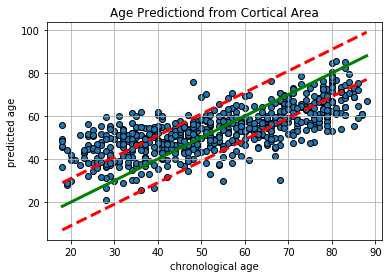

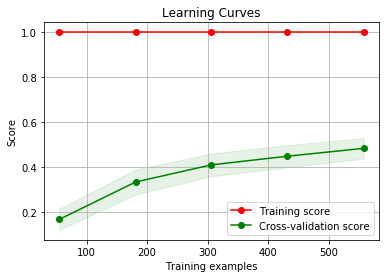

In [7]:
y, y_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores = run_ridge(area_data, subjects_data)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

plot_pred(y, y_pred, mae, title='Age Predictiond from Cortical Area')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Thickness

MAE: 7.24
MAE STD: 0.55


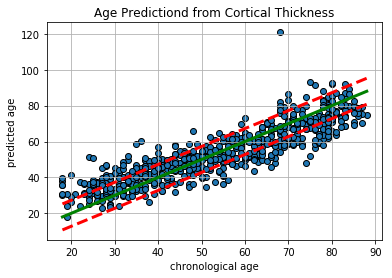

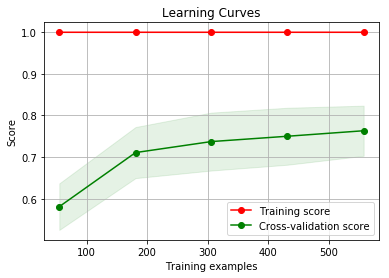

In [8]:
y, y_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores = run_ridge(thickness_data, subjects_data)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

plot_pred(y, y_pred, mae, title='Age Predictiond from Cortical Thickness')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Volume

MAE: 9.85
MAE STD: 7.88


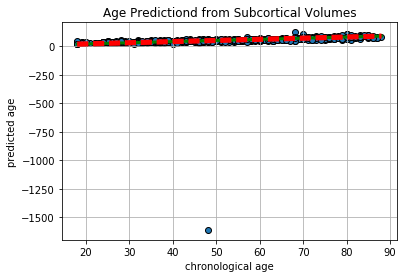

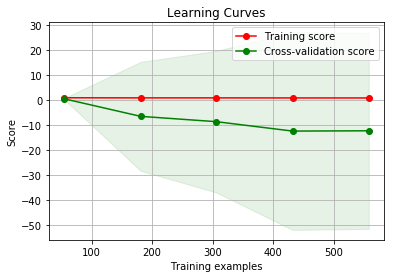

In [9]:
y, y_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores = run_ridge(volume_data, subjects_data)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

plot_pred(y, y_pred, mae, title='Age Predictiond from Subcortical Volumes')
plot_learning_curve(train_sizes, train_scores, test_scores)

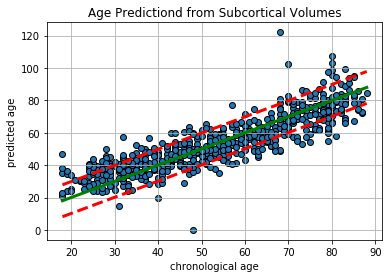

In [10]:
# We have an outlier with negative age, what should we do about it?
y_pred[y_pred < 0] = 0

plot_pred(y, y_pred, mae, title='Age Predictiond from Subcortical Volumes')

## Functional MRI

In [11]:
# read connectivity data
connect_data = pd.read_pickle('../../data/connectivity/connect_data_basc064_correlation.gzip',
                              compression='gzip')
connect_data.head()

,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
CC110033,1.004289,0.966713,0.822236,1.197068,1.036533,0.967226,0.720311,0.550827,0.724289,0.735232,...,1.090760,0.913631,0.740986,0.916093,1.086894,0.938503,1.105323,0.898267,0.668928,0.999819
CC110037,1.082826,0.813908,0.937486,0.686340,0.727605,0.840325,0.693621,0.876473,0.696417,0.485488,...,0.493022,0.098099,0.294668,0.326665,0.931432,0.232320,0.266360,0.373488,0.000000,0.265720
CC110045,0.749952,0.695596,0.675277,0.910891,0.832301,0.712758,0.850892,0.605811,0.832450,0.738039,...,0.974620,0.530629,0.931266,0.884653,0.866690,0.860431,0.635074,0.818768,0.608298,0.896205
CC110069,0.755715,0.525945,0.600657,0.794172,0.598672,0.521180,0.998562,0.639526,0.400922,0.793610,...,1.443472,1.369850,0.996413,1.273953,1.149168,1.195334,1.289097,0.985435,1.154993,1.108115
CC110087,0.971724,0.784285,0.898497,1.195576,1.043518,0.893169,0.685567,0.531968,0.660930,0.703288,...,1.250349,1.262096,1.226539,0.973966,1.349988,1.282173,1.162553,1.146275,1.070162,1.176189


MAE: 8.26
MAE STD: 0.47


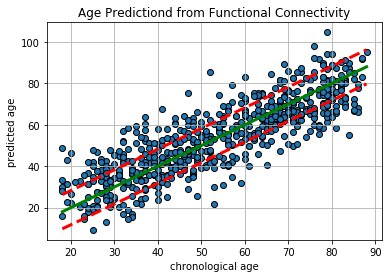

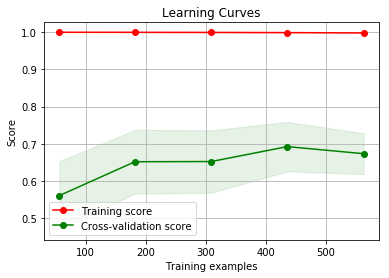

In [12]:
y, y_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores = run_ridge(connect_data, subjects_data)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

plot_pred(y, y_pred, mae, title='Age Predictiond from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)